In [20]:
import timeit
import numpy as np
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt

# Read the CSV file directly into a NumPy array
data_array = np.genfromtxt("cancer_data.csv", delimiter=',')

# Extract X and y from the data array
X_before_normalize = data_array[:, :-1]  # choose all columns except the last one
y_before_normalize = data_array[:, -1]   # choose the last column to be the y to predict

# Normalize X and y
X_mean = np.mean(X_before_normalize, axis=0)
X_std = np.std(X_before_normalize, axis=0)
y_mean = np.mean(y_before_normalize, axis=0)
y_std = np.std(y_before_normalize, axis=0)
X_normalize = (X_before_normalize - X_mean) / X_std
y_normalize = (y_before_normalize - y_mean) / y_std

# normalization check:
#X.mean(X_normalize,axis=0)
#np.mean(y_normalize,axis=0)
#np.std(X_normalize,axis=0)
#np.std(y_normalize,axis=0)

X_normalize_no_intercept = X_normalize.copy()

# Add intercept to X
intercept = np.ones((X_normalize.shape[0], 1))
X_normalize = np.concatenate((intercept, X_normalize), axis=1)

# Combine X and y into a single array
shuffled_data = np.concatenate((X_normalize, y_normalize[:, np.newaxis]), axis=1)

# Shuffle the data
np.random.seed(42)
np.random.shuffle(shuffled_data)


## functions:

In [21]:
def h(X,theta): # linear regression
    return np.dot(X, theta)

In [22]:
def cost_J(X,y,theta):
    m=X.shape[0] # the number of rows 
    return (1/(2*m))*((np.linalg.norm(h(X,theta)-y))**2)

In [23]:
def grad_J(X,y,theta):
    m=X.shape[0]
    predictions = h(X,theta)
    errors=(predictions-y)
    # Compute gradient using matrix multiplication:
    return (1/m)*(np.dot(X.T,errors))

In [24]:
def SGD(X,y,alpha=0.01,epochs=100):
    cost_per_theta = []
    sgd_theta=np.zeros(X.shape[1]) # initial guess
    for _ in range(epochs):
        current_cost=cost_J(X,y,sgd_theta)
        cost_per_theta.append(current_cost)
        ## Update theta using Stochastic Gradient Descent
        sgd_theta=sgd_theta-alpha*grad_J(X,y,sgd_theta) 
        
    return cost_per_theta
    

In [25]:
def batch_gradient_descent(shuffled_data, X, y, alpha=0.1,epochs=100, b=64):
    cost_by_theta =[]
    current_theta = np.zeros(X.shape[1])
    len_of_data = len(shuffled_data)
    for index in range(epochs):
        current_cost = cost_J(X,y,theta=current_theta)
        cost_by_theta.append(current_cost)
        # Select a mini-batch of size b from the data:
        start_index = (index*b)%len_of_data
        end_index = ((index*b) + b)%len_of_data
        
        if end_index <= start_index:
            start_index = 0
            end_index = b 
       
        # Update theta using batch gradient descent:
        current_theta=current_theta-alpha*grad_J(X=shuffled_data[start_index:end_index,:-1],y=shuffled_data[start_index:end_index,-1],theta= current_theta) 
    return cost_by_theta

## Vanilla with different alphas:

In [26]:
def vanilla_for_different_alpha(X, y, epochs=100):
  fig, axs = plt.subplots(1, 4, figsize=(15, 5))
  alpha_arr = [0.3, 0.1, 0.01, 0.001]

  # runing gradient descent 4 times with different alphas:
  for i, alpha in enumerate(alpha_arr):
    cost_per_alpha=SGD(X,y,alpha=alpha,epochs=epochs)

    axs[i].plot(np.arange(1, len(cost_per_alpha) + 1),cost_per_alpha,"o")
    axs[i].set_xlabel(f'Iteration number')
    axs[i].set_ylabel("Cost - J(theta)")  
    axs[i].set_title(f'Cost vs. Iterations (alpha={alpha})')


  plt.tight_layout()
  plt.show()  

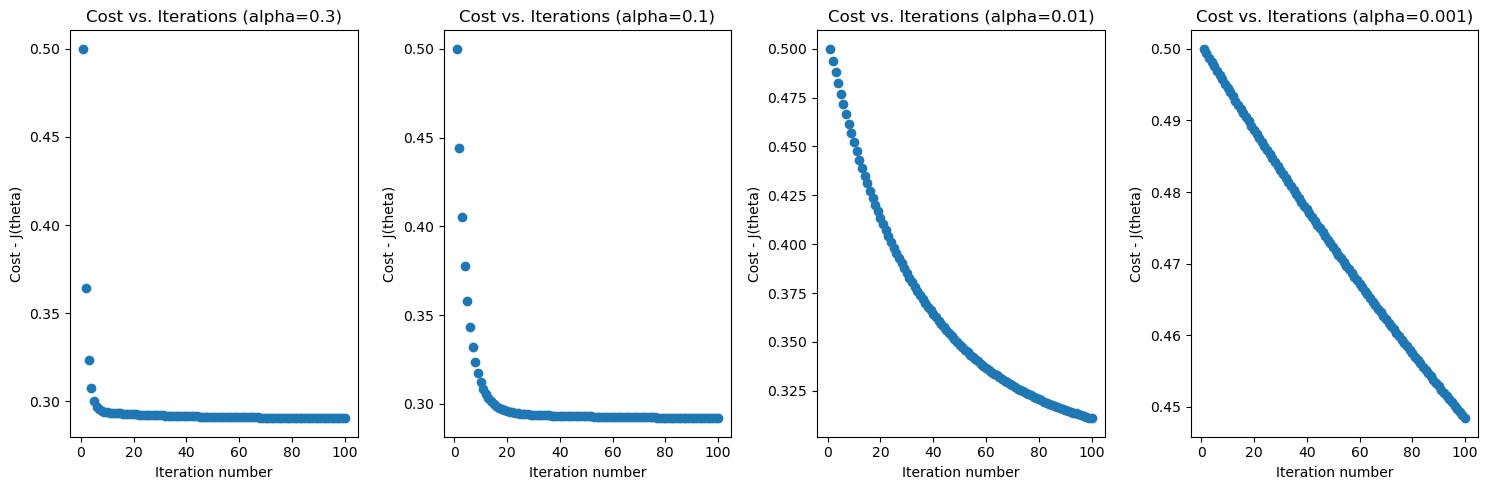

In [27]:
vanilla_for_different_alpha(X_normalize, y_normalize)

conclusions: 
from the alpha's that we tested the best alpha is 0.3,
because it is both stable and converges the fastest, meaning only about 10 iterations are enough to reach a minimal cost


## Mini batch with different alphas and different b:

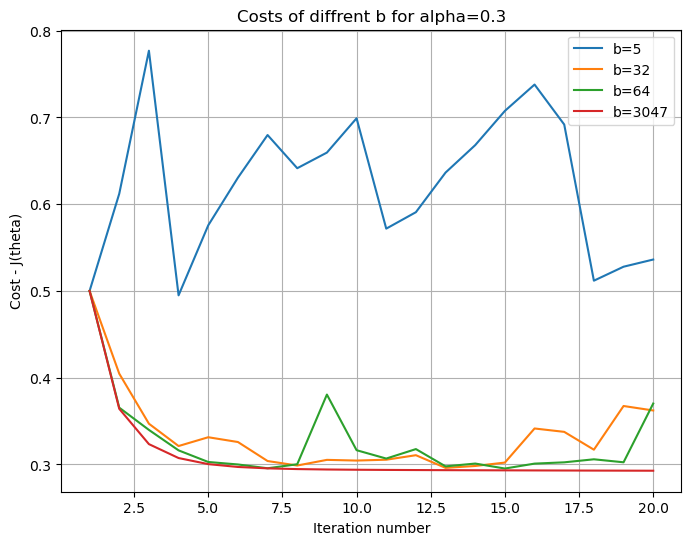

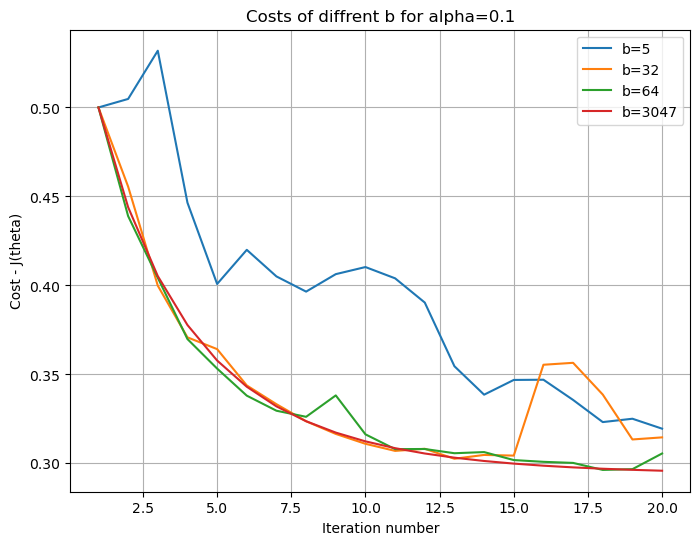

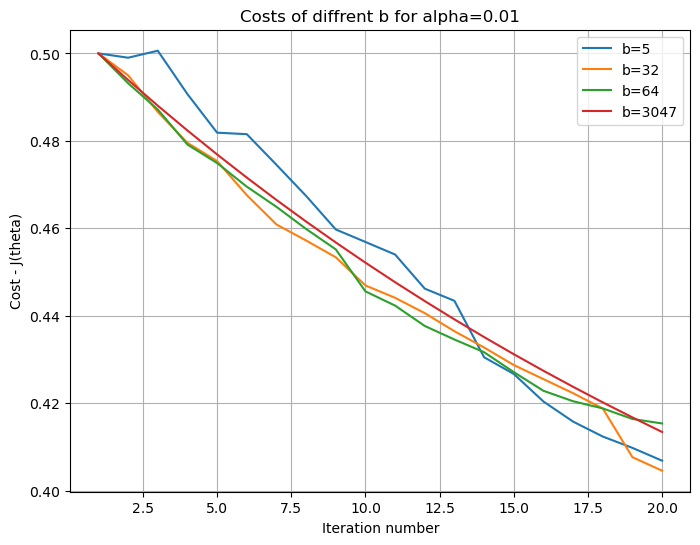

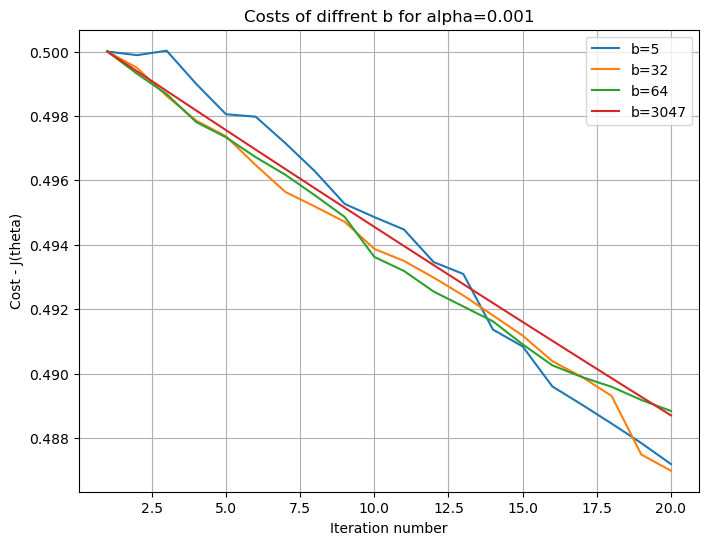

In [28]:

alphas = [0.3, 0.1, 0.01, 0.001]

# Iterate over each alpha value
for alpha in alphas:
    cost_per_b = []
    batch = [5, 32,64,3047]

    for b in batch: 
        temp = batch_gradient_descent(shuffled_data, X_normalize, y_normalize, alpha, epochs=20, b=b)
        cost_per_b.append(temp)

    
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(1,21),cost_per_b[0],label="b=5")
    plt.plot(np.arange(1,21),cost_per_b[1],label="b=32")
    plt.plot(np.arange(1,21),cost_per_b[2],label="b=64")
    plt.plot(np.arange(1,21),cost_per_b[3],label="b=3047")

    plt.title(f"Costs of diffrent b for alpha={alpha}")
    plt.xlabel("Iteration number")
    plt.ylabel("Cost - J(theta)")

    plt.legend()
    plt.grid(True)
    plt.show()


Upon examination, it becomes evident that compared to a batch size of 3047 (representing the vanilla approach that utilizes the complete gradient), a batch size of 64 proves to be sufficient for cost calculation. Moreover, even a smaller batch size, such as 32, demonstrates stability in most instances. However, it's notable that when the batch size becomes excessively small, stability diminishes significantly. Consequently, it's prudent to select a batch size of 64 from the range of batch sizes tested, as it strikes a balance between computational efficiency and stability, ensuring reliable and efficient optimization processes.

## Mini batch with different alphas and the const b:

In [29]:
def mini_batch_different_alpha(shuffled_data , X, y, epochs=100, batch=64):

  # Plotting all three alpha values in one line with subplots
  fig, axs = plt.subplots(1, 4, figsize=(15, 5))
  alpha_arr = [0.3, 0.1, 0.01, 0.001]

  for i, alpha in enumerate(alpha_arr):
    cost_per_alpha=batch_gradient_descent(shuffled_data, X,y,alpha, epochs=epochs,b=batch)

    axs[i].plot(np.arange(1, len(cost_per_alpha) + 1), cost_per_alpha, "o")
    axs[i].set_xlabel(f'Iteration Number')
    axs[i].set_ylabel('Cost - J(theta)')
    axs[i].set_title(f'Cost vs. Iterations (alpha={alpha})')

  plt.tight_layout()
  plt.show() 

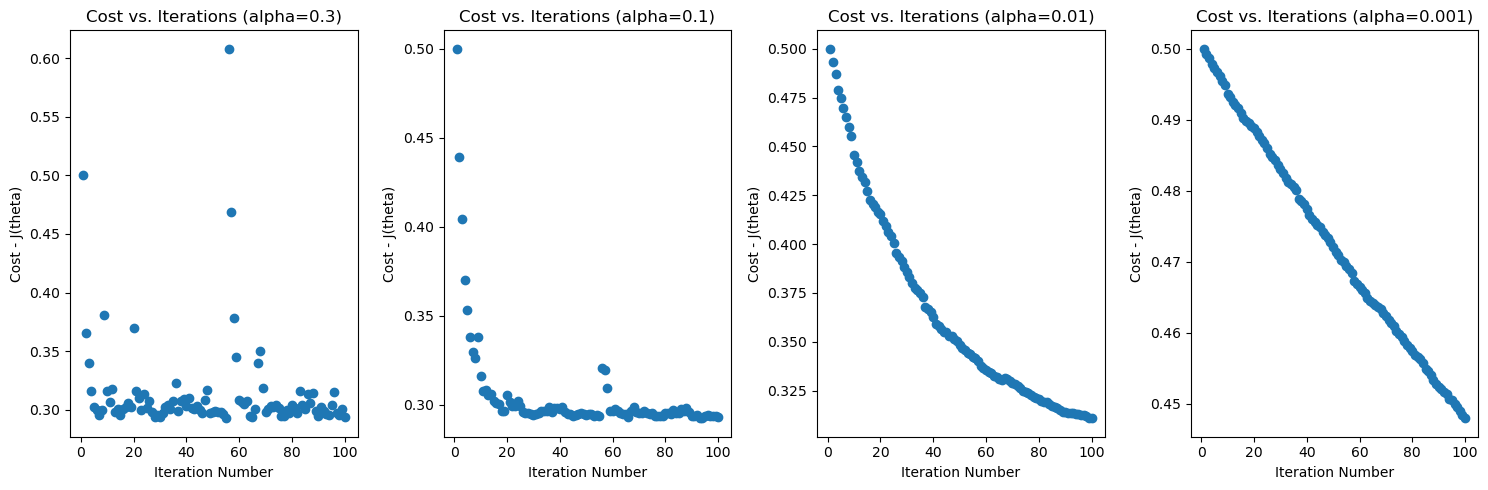

In [30]:
mini_batch_different_alpha(shuffled_data, X_normalize, y_normalize)

conclusions: 
from the alpha's that we tested the best alpha is 0.1,
Although it is less stable than the smaller alphas, it converges much faster than them.
And even if we stop at his jump at iteration 60, the cost is still smaller than iteration 80 when the alphas are smaller.

In summary, the vanilla method demonstrates greater stability compared to the batch approach. With vanilla, we could afford a larger alpha that converges swiftly yet remains stable, requiring approximately 10 iterations to reach minimal cost. Conversely, the batch method necessitates a smaller alpha, resulting in roughly 20 iterations to achieve a minimum cost. However, despite the increased iteration count, the batch approach remains advantageous due to its efficiency. Batch processing involves only 64 samples per iteration in our scenario, contrasting with vanilla, which traverses all 3047 samples in each iteration. This streamlined sampling process contributes to faster convergence and computational efficiency, making the batch method a preferred choice. 

### In conclusion, based on the observed results, it is advisable to utilize a batch size of 64 coupled with an alpha value of 0.1 for optimal performance in the gradient descent algorithm.

## SVD:

In [31]:
import numpy as np

# Assuming X_normalize_no_intercept and y_normalize are defined

# Perform Singular Value Decomposition (SVD) using NumPy
U, S, Vt = np.linalg.svd(X_normalize_no_intercept, full_matrices=False)

# Keep only the first 3 components
U = U[:, :3]
S = np.diag(S[:3])
Vt = Vt[:3, :]

# Transform the input data X
X_svd = U.dot(S)
# Add intercept to X
intercept = np.ones((X_svd.shape[0], 1))
X_svd = np.concatenate((intercept, X_svd), axis=1)
print(X_svd)
# Combine X and y into a single array
shuffled_data_svd = np.concatenate((X_svd, y_normalize[:, np.newaxis]), axis=1)

# Shuffle the data
np.random.seed(42)
np.random.shuffle(shuffled_data_svd)

[[ 1.         -1.41259194  0.49955     1.01863405]
 [ 1.         -0.21412532 -1.93620118  1.04827874]
 [ 1.          0.76152944  1.04098489  0.14001791]
 ...
 [ 1.         -1.16459266 -1.94950308  1.47890096]
 [ 1.         -0.55768123 -0.08951267  0.66681779]
 [ 1.         -1.35156534 -3.13064649  1.60731564]]


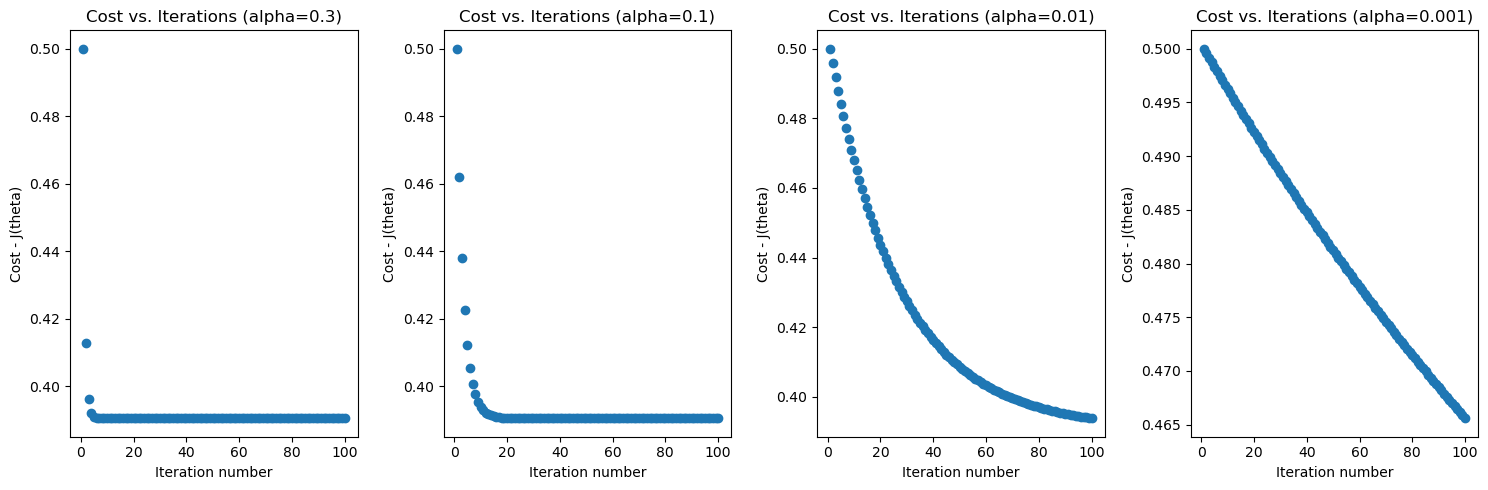

In [32]:
vanilla_for_different_alpha(X_svd,y_normalize)

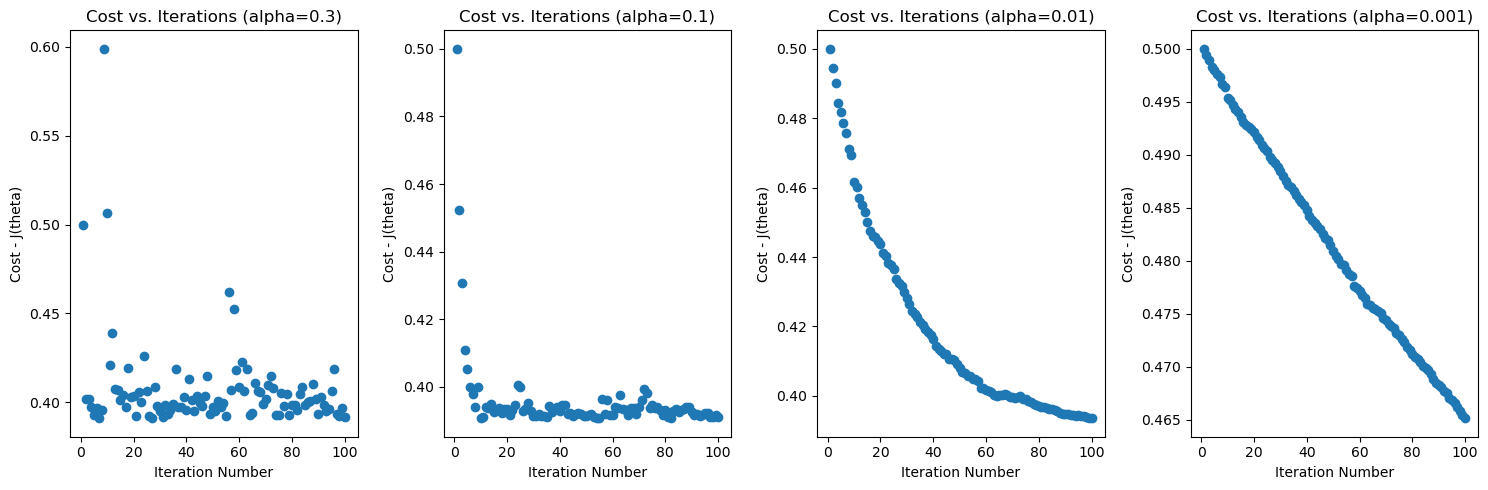

In [33]:
mini_batch_different_alpha(shuffled_data_svd, X_svd,y_normalize)

In our analysis, we discovered that implementing dimensionality reduction via SVD successfully maintains the vital information of the dataset. However, this technique does incur a slightly higher computational cost compared to running without SVD. This cost arises because SVD reduces the dimensionality of the data, which consequently leads to the loss of some information.

## Run time testing:

In [34]:

num_repetitions = 10

# Define the callable object (function) to test
def function_to_test2():
  SGD(X_svd,y_normalize)

execution_times = []
for _ in range(num_repetitions):
    execution_time2 = timeit.timeit(function_to_test2, number=1)
    execution_times.append(execution_time2)

# Calculate the average execution time
average_execution_time = np.mean(execution_times)
print(f'Vanilla SGD with SVD, average run time: {average_execution_time}')


# Define the callable object (function) to test
def function_to_test1():
  batch_gradient_descent(shuffled_data_svd, X_svd,y_normalize)

execution_times = []
for _ in range(num_repetitions):
    execution_time1 = timeit.timeit(function_to_test1, number=1)
    execution_times.append(execution_time1)

# Calculate the average execution time
average_execution_time = np.mean(execution_times)
print(f'Batch SGD with SVD, average run time: {average_execution_time}')


Vanilla SGD with SVD, average run time: 0.007738759997300804
Batch SGD with SVD, average run time: 0.004379720008000731


In [35]:
# Define the callable object (function) to test
def function_to_test4():
  SGD(X_normalize,y_normalize)

execution_times = []
for _ in range(num_repetitions):
    execution_time = timeit.timeit(function_to_test4, number=1)
    execution_times.append(execution_time)

# Calculate the average execution time
average_execution_time = np.mean(execution_times)
print(f'Vanilla SGD, average run time: {average_execution_time}')


# Define the callable object (function) to test
def function_to_test3():
  batch_gradient_descent(shuffled_data, X_normalize,y_normalize)

execution_times = []
for _ in range(num_repetitions):
    execution_time = timeit.timeit(function_to_test3, number=1)
    execution_times.append(execution_time)

# Calculate the average execution time
average_execution_time = np.mean(execution_times)
print(f'Batch SGD, average run time: {average_execution_time}')

Vanilla SGD, average run time: 0.014812659996096045
Batch SGD, average run time: 0.005141750012990087


#### The difference between vanilla and batch: 
<font color='green'>
Batch training is faster than vanilla training because it processes a subset of the data in each iteration, while vanilla training goes through all data samples in every iteration. In our case, with a batch size of 64, batch training only handles a fraction of the data per iteration, leading to shorter overall runtime compared to vanilla training.
</font>

#### The difference between svd and regular data:
<font color='green'>
Using SVD for dimensionality reduction resulted in faster runtime, as we dealt with only 3 columns instead of the original 10.
</font>


<font color='blue'>
In summary:
The runtime differences between using SVD and not using SVD were not particularly significant, given the small size of the dataset. Therefore, for small datasets, the computational savings from using SVD were minimal. However, for larger datasets, sacrificing a bit of accuracy for reduced computational time, as achieved through SVD, might be a worthwhile trade-off. On the other hand, for relatively small datasets where computational efficiency is less critical, sticking with the original data to obtain more accurate results could be preferable.
</font>